### PROJET - EXPLORATION DES DONNEES + DATAVIZ

Importation des librairies

In [314]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from PIL import Image, ImageChops
import os
import random
from scipy.stats import f_oneway, levene, shapiro, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from skimage import io, color, transform
from skimage.transform import resize

from sklearn.preprocessing import MinMaxScaler


Importation des metadata et infos de ceux-ci

In [36]:
covid = pd.read_excel('/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID.metadata.xlsx')

lung_opacity = pd.read_excel('/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/Lung_Opacity.metadata.xlsx')

normal = pd.read_excel('/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/Normal.metadata.xlsx')

viral_pneumonia = pd.read_excel('/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/Viral_Pneumonia.metadata.xlsx')

In [37]:
#afficher les infos covid
display(covid.info())
print("----------------------")

#afficher les infos de normal
display(normal.info())
print("----------------------")

#afficher les infos de lung_opacity
display(lung_opacity.info())
print("----------------------")

#afficher les infos de viral_pneumonia
display(viral_pneumonia.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3616 entries, 0 to 3615
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FILE NAME  3616 non-null   object
 1   FORMAT     3616 non-null   object
 2   SIZE       3616 non-null   object
 3   URL        3616 non-null   object
dtypes: object(4)
memory usage: 113.1+ KB


None

----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10192 entries, 0 to 10191
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FILE NAME  10192 non-null  object
 1   FORMAT     10192 non-null  object
 2   SIZE       10192 non-null  object
 3   URL        10192 non-null  object
dtypes: object(4)
memory usage: 318.6+ KB


None

----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012 entries, 0 to 6011
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FILE NAME  6012 non-null   object
 1   FORMAT     6012 non-null   object
 2   SIZE       6012 non-null   object
 3   URL        6012 non-null   object
dtypes: object(4)
memory usage: 188.0+ KB


None

----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FILE NAME  1345 non-null   object
 1   FORMAT     1345 non-null   object
 2   SIZE       1345 non-null   object
 3   URL        1345 non-null   object
dtypes: object(4)
memory usage: 42.2+ KB


None

Les metadatas ont les mêmes colonnes par conséquent on va les concaténer en un seul dataframe

In [39]:
#concaténation des 4 dataframes
df  = pd.concat([covid, normal, lung_opacity, viral_pneumonia], ignore_index=True, join='inner')

#On renomme la colonne 'FILE NAME' en 'FILE_NAME' (pas fan des espaces)
df = df.rename(columns={'FILE NAME': 'FILE_NAME'})

df

,FILE_NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
...,...,...,...,...
21160,Viral Pneumonia-1341,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
21161,Viral Pneumonia-1342,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
21162,Viral Pneumonia-1343,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
21163,Viral Pneumonia-1344,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...


Analyse exploratoire Metadata

In [41]:
#Création d'une colonne 'FILE SOURCE' dans laquelle on précise de quelle dataset provient le fichier
df['FILE_SOURCE'] = df['FILE_NAME'].str.split('-').str[0]

In [35]:
#On vérifie si cela a fonctionné en affichant les valeurs uniques 'FILE SOURCE'
df['FILE SOURCE'].unique()

array(['COVID', 'NORMAL', 'Lung_Opacity', 'Viral Pneumonia'], dtype=object)

In [84]:
#On sait aussi que les colonnes FORMAT et SIZE ont une unique valeur
print("Format :",df['FORMAT'].unique())
print("Résolution :",df['SIZE'].unique())

Format : ['PNG']
Résolution : ['256*256']


In [50]:
# On va donc s'intéresser aux URL d'où proviennent les données

#On affiche pour chaque source de metadata, le nombre d'URL unique d'où proviennent les données
file_source_unique_url_counts = df.groupby('FILE_SOURCE')['URL'].nunique()
file_source_unique_url_counts

FILE_SOURCE
COVID              6
Lung_Opacity       1
NORMAL             2
Viral Pneumonia    1
Name: URL, dtype: int64

In [282]:
# Définir les couleurs personnalisées
colors = ['salmon', 'mediumseagreen','peachpuff', 'orange']

# Trier les données par ordre décroissant du nombre d'URLs uniques
sorted_data = file_source_unique_url_counts.sort_values(ascending=False)

# Créer les données pour le diagramme en barres
data = [
    go.Bar(
        x=sorted_data.index,  # Catégories (Metadata)
        y=sorted_data.values,  # Nombre d'URLs uniques (trouvées)
        marker=dict(color=colors)  # Utiliser la palette de couleurs personnalisée
    )
]

# Créer la mise en page du diagramme
layout = go.Layout(
    title='Number of references per sample type',
    xaxis=dict(title='Metadata'),
    yaxis=dict(title='Count of unique URL')
)

# Créer la figure
fig = go.Figure(data=data, layout=layout)

# Afficher la figure
fig.show()

Nombre d'images par catégorie

In [281]:
directories = {
    "COVID": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/COVID/images",
    "NORMAL": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/Normal/images",
    "lung_opacity": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/Lung_Opacity/images",
    "viral_pneumonia": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/Viral_Pneumonia/images"
}

# Définir les couleurs personnalisées
colors = ['mediumseagreen', 'peachpuff', 'salmon', 'orange']

# Fonction pour compter le nombre d'images dans un répertoire
def count_images(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Compter le nombre d'images dans chaque catégorie
image_counts = {category: count_images(directory) for category, directory in directories.items()}

# Trier les catégories par nombre d'images (ordre décroissant)
sorted_categories = sorted(image_counts, key=image_counts.get, reverse=True)
sorted_counts = [image_counts[category] for category in sorted_categories]

# Créer le diagramme en barres avec les couleurs personnalisées
fig = go.Figure(data=[go.Bar(
    x=sorted_categories, y=sorted_counts,
    text=sorted_counts, textposition='auto',
    marker_color=colors
)])

# Mettre en forme le graphique
fig.update_layout(title='Number of images per sample type',
                  xaxis=dict(title=''),
                  yaxis=dict(title='Count of images'))

# Afficher le graphique
fig.show()

Analyse exploratoire des images 

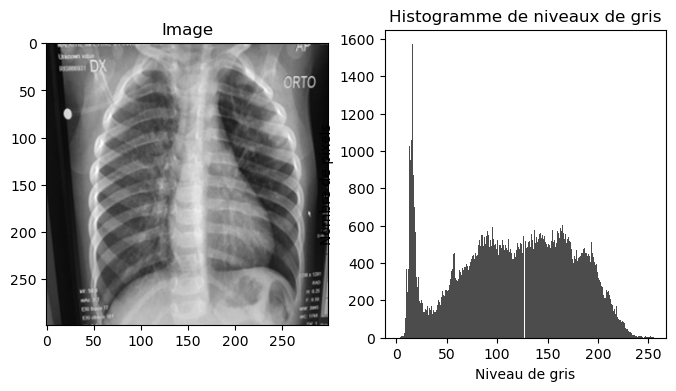

In [225]:
# Charger une image
image_path = "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/COVID/images/COVID-4.png"
image = Image.open(image_path).convert("L")  # Convertir en niveaux de gris

# Afficher l'image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Image')


# Afficher l'histogramme
plt.subplot(1, 2, 2)
plt.hist(image.getdata(), bins=256, color='black', alpha=0.7)
plt.title('Histogramme de niveaux de gris')
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')

plt.show()



Inspection de 4 images de patients atteint de COVID, sains, présentant une opacité pulmonaire et atteint d'une pneumonie virale

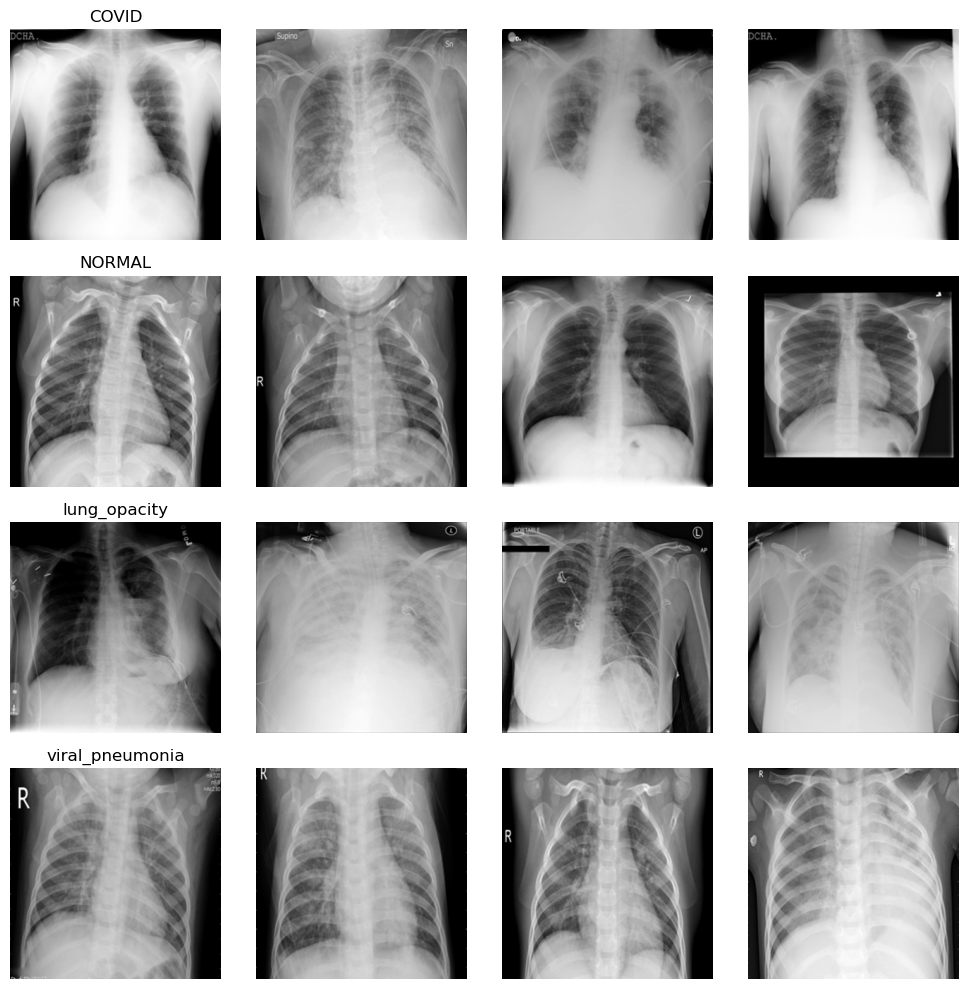

In [226]:
# Chemin vers les répertoires contenant les images de chaque catégorie
directories = {
    "COVID": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID",
    "NORMAL": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL",
    "lung_opacity": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity",
    "viral_pneumonia": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia"
}

# Création de la figure
plt.figure(figsize=(10, 10))

# Parcourir les répertoires et afficher quatre images aléatoires de chaque catégorie
for i, (category, directory) in enumerate(directories.items(), 1):
    # Lister les fichiers dans le répertoire
    files = os.listdir(directory)
    # Sélectionner quatre images aléatoires de la catégorie
    random_files = random.sample(files, 4)
    # Afficher les quatre images
    for j, file in enumerate(random_files, 1):
        # Construire le chemin d'accès complet de l'image
        image_path = os.path.join(directory, file)
        # Charger l'image
        image = Image.open(image_path)
        # Ajouter l'image à la figure
        plt.subplot(4, 4, (i-1)*4 + j)
        plt.imshow(image, cmap='gray')
        plt.title(category if j == 1 else '')  # Ne montrer le titre que pour la première image de chaque catégorie
        plt.axis('off')

# Afficher la figure
plt.tight_layout()
plt.show()

Inspection des niveaux de gris pour 4 images de patients atteint de COVID, sains, présentant une opacité pulmonaire et atteint d'une pneumonie virale

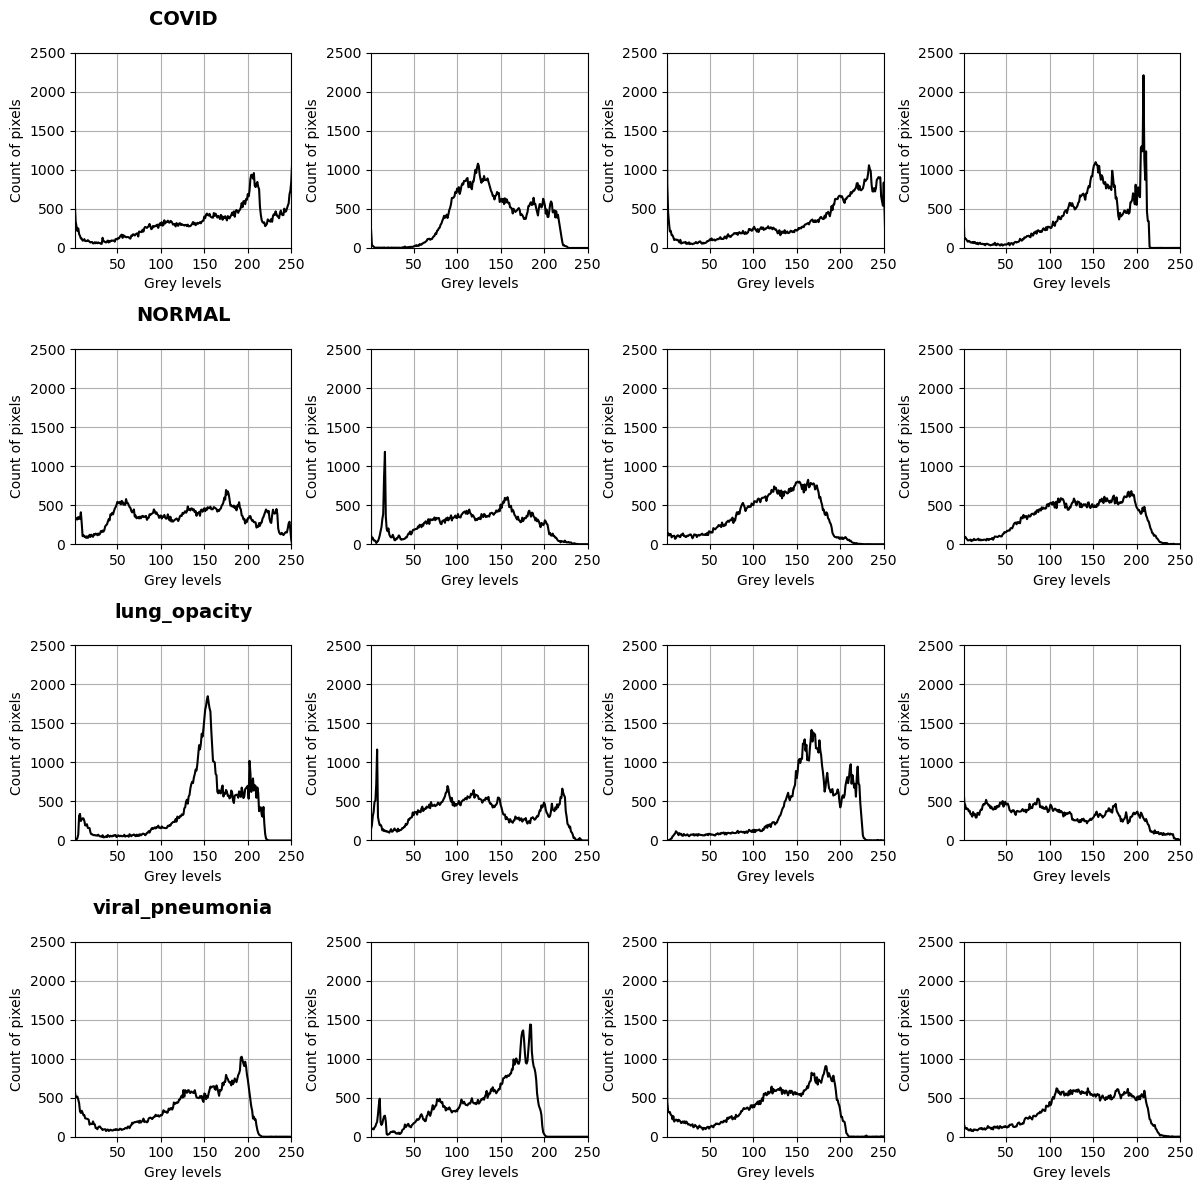

In [285]:
# Fonction pour créer un histogramme de niveaux de gris
def plot_grayscale_histogram(image_path, ax):
    # Charger l'image en niveaux de gris
    image = Image.open(image_path).convert("L")
    # Calculer l'histogramme des niveaux de gris
    histogram = image.histogram()
    # Afficher l'histogramme
    ax.plot(histogram, color='black')
    ax.set_xlabel("Grey levels")
    ax.set_ylabel("Count of pixels")
    ax.set_ylim(0, 2500)
    ax.set_xlim(1, 250) #on le fait commencer à 1 car il y a beaucoup de pixels qui ont 0 pour valeur de gris

    ax.grid(True)

# Chemin vers les répertoires contenant les images de chaque catégorie
directories = {
    "COVID": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID",
    "NORMAL": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL",
    "lung_opacity": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity",
    "viral_pneumonia": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia"
}

# Création de la figure
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Parcourir les répertoires et afficher les histogrammes de niveaux de gris de quatre images aléatoires de chaque catégorie
for i, (category, directory) in enumerate(directories.items()):
    # Lister les fichiers dans le répertoire
    files = os.listdir(directory)
    # Sélectionner quatre images aléatoires de la catégorie
    random_files = random.sample(files, 4)
    # Afficher les histogrammes de niveaux de gris
    for j, file in enumerate(random_files):
        # Construire le chemin d'accès complet de l'image
        image_path = os.path.join(directory, file)
        # Créer un histogramme de niveaux de gris pour l'image et l'afficher
        plot_grayscale_histogram(image_path, axs[i, j])
        
    # Ajouter le titre de chaque catégorie au-dessus de la ligne
    axs[i, 0].set_title(category, fontsize=14, weight='bold', pad=20)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher la figure
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1319: UserWarning:

Horizontal orientation ignored with only `y` specified.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1319: UserWarning:

Horizontal orientation ignored with only `y` specified.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1319: UserWarning:

Horizontal orientation ignored with only `y` specified.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1319: UserWarning:

Horizontal orientation ignored with only `y` specified.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1319: UserWarning:

Horizontal orientation ignored with only `y` specified.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1319: UserWarning:

Horizontal orientation ignored with only `y` specified.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1319: UserWarning:

Horizontal orientation ignored with only `y` specified.

/opt/anaconda3/lib/python3.9/site-package

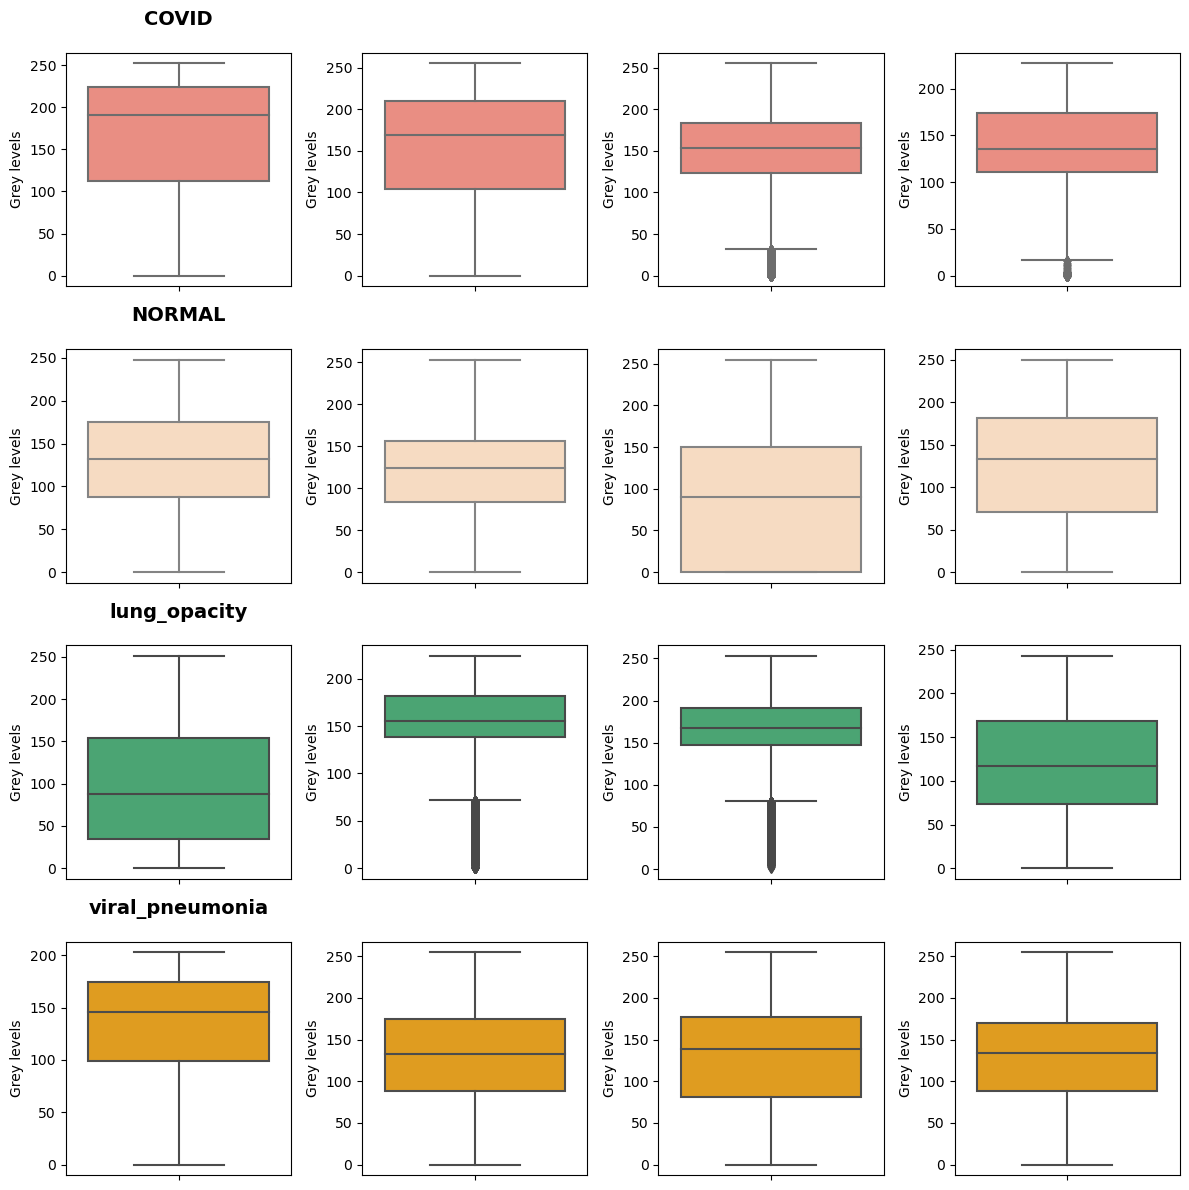

In [287]:
# Définir une palette de couleurs avec quatre couleurs
colors = ['salmon', 'peachpuff', 'mediumseagreen', 'orange']

# Fonction pour créer un boxplot de niveaux de gris avec une couleur spécifique pour chaque catégorie
def plot_grayscale_boxplot(image_path, ax, color):
    # Charger l'image en niveaux de gris
    image = Image.open(image_path).convert("L")
    # Récupérer les niveaux de gris
    grayscale_values = list(image.getdata())
    # Afficher le boxplot avec une couleur spécifique
    sns.boxplot(y=grayscale_values, ax=ax, orient='h', color=color)
    ax.set_ylabel("Grey levels")
    ax.set_xlabel("")

# Chemin vers les répertoires contenant les images de chaque catégorie
directories = {
    "COVID": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID",
    "NORMAL": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL",
    "lung_opacity": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity",
    "viral_pneumonia": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia"
}

# Création de la figure
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Parcourir les répertoires et afficher les boxplots de niveaux de gris de quatre images aléatoires de chaque catégorie
for i, (category, directory) in enumerate(directories.items()):
    # Lister les fichiers dans le répertoire
    files = os.listdir(directory)
    # Sélectionner quatre images aléatoires de la catégorie
    random_files = random.sample(files, 4)
    # Afficher les boxplots de niveaux de gris avec une couleur spécifique
    for j, file in enumerate(random_files):
        # Construire le chemin d'accès complet de l'image
        image_path = os.path.join(directory, file)
        # Créer un boxplot de niveaux de gris pour l'image et l'afficher
        plot_grayscale_boxplot(image_path, axs[i, j], color=colors[i])
        
    # Ajouter le titre de chaque catégorie au-dessus de la ligne
    axs[i, 0].set_title(category, fontsize=14, weight='bold', pad=20)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher la figure
plt.show()

Test statistique ANOVA pour vérifier s'il y a une différence significative des niveaux de gris des 4 types d'images

(à savoir que sur un mac, le téléchargement total des fichiers depuis Kaggle et leur décompression peut générer des fichiers cachers. Pour chaque 
dossier d'images et de masques, il faut aller dessus avec le terminal, les afficher : "ls -la" et les supprimer : find . -type f -name "._*" -delete)

In [234]:
#On récupère les valeurs de niveaux de gris et on les stocke dans des listes

# Chemin vers les répertoires contenant les images de chaque catégorie
directories = {
    "COVID": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/COVID/images",
    "NORMAL": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/Normal/images",
    "lung_opacity": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/Lung_Opacity/images",
    "viral_pneumonia": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/Viral_Pneumonia/images"
}

# Fonction pour récupérer les niveaux de gris d'une image
def get_grayscale_values(image_path):
    # Charger l'image et la convertir en niveaux de gris
    image = Image.open(image_path).convert("L")
    # Récupérer les niveaux de gris
    grayscale_values = list(image.getdata())
    return grayscale_values



# Listes pour stocker les niveaux de gris de chaque catégorie
grayscale_values_covid = []
grayscale_values_normal = []
grayscale_values_lung_opacity = []
grayscale_values_viral_pneumonia = []

# Parcourir les répertoires et récupérer les niveaux de gris de chaque image
for category, directory in directories.items():
    # Lister les fichiers dans le répertoire
    files = os.listdir(directory)
    # Récupérer les niveaux de gris de chaque image
    for file in files:
        # Construire le chemin d'accès complet de l'image
        image_path = os.path.join(directory, file)
        # Récupérer les niveaux de gris de l'image
        grayscale_values = get_grayscale_values(image_path)
        # Ajouter les niveaux de gris à la liste correspondante en fonction de la catégorie
        if category == "COVID":
            grayscale_values_covid.extend(grayscale_values)
        elif category == "NORMAL":
            grayscale_values_normal.extend(grayscale_values)
        elif category == "lung_opacity":
            grayscale_values_lung_opacity.extend(grayscale_values)
        elif category == "viral_pneumonia":
            grayscale_values_viral_pneumonia.extend(grayscale_values)

# Vérification
print("Nombre de niveaux de gris pour la catégorie COVID :", len(grayscale_values_covid))
print("Nombre de niveaux de gris pour la catégorie NORMAL :", len(grayscale_values_normal))
print("Nombre de niveaux de gris pour la catégorie lung_opacity :", len(grayscale_values_lung_opacity))
print("Nombre de niveaux de gris pour la catégorie viral_pneumonia :", len(grayscale_values_viral_pneumonia))



Nombre de niveaux de gris pour la catégorie COVID : 323274016
Nombre de niveaux de gris pour la catégorie NORMAL : 911174992
Nombre de niveaux de gris pour la catégorie lung_opacity : 537478812
Nombre de niveaux de gris pour la catégorie viral_pneumonia : 120244345


In [ ]:
#Comme les 4 arrays sont de tailles différents, on crée une fonction qui sélectionne 
#aléatoirement un nombre de valeurs équivalent au plus petit des quatre tableaux et les utilisera pour créer un DataFrame avec ces valeurs.

'''
def generate_random_dataframe(array1, array2, array3, array4):
    # Sélectionner le nombre minimum de valeurs parmi les quatre listes
    min_length = min(len(array1), len(array2), len(array3), len(array4))
    
    # Sélectionner aléatoirement des indices pour chaque liste
    random_indices = np.random.choice(min_length, min_length, replace=False)
    
    # Sélectionner les valeurs correspondantes à ces indices pour chaque liste
    selected_values = {
        'COVID': [array1[i] for i in random_indices],
        'NORMAL': [array2[i] for i in random_indices],
        'lung_opacity': [array3[i] for i in random_indices],
        'viral_pneumonia': [array4[i] for i in random_indices]
    }
    
    # Créer le DataFrame
    data = pd.DataFrame(selected_values)
    
    return data

generate_random_dataframe(grayscale_values_covid, grayscale_values_normal, grayscale_values_lung_opacity, grayscale_values_viral_pneumonia)
'''


#Cette fonction prend beaucoup de temps à s'exécuter et consomme beaucoup. Du coup on va simplement sélectionner 50 entrées au hasard pour chaque array

In [256]:

min_length = min(len(grayscale_values_covid), len(grayscale_values_normal), len(grayscale_values_lung_opacity), len(grayscale_values_viral_pneumonia))
random_indices = np.random.choice(min_length, 50, replace=False)
selected_values = {
        'COVID': [grayscale_values_covid[i] for i in random_indices],
        'NORMAL': [grayscale_values_normal[i] for i in random_indices],
        'lung_opacity': [grayscale_values_lung_opacity[i] for i in random_indices],
        'viral_pneumonia': [grayscale_values_viral_pneumonia[i] for i in random_indices]
    }
data = pd.DataFrame(selected_values)


In [257]:
# Test de Levene pour l'homoscédasticité
levene_statistic, levene_pvalue = levene(data['COVID'], data['NORMAL'], data['lung_opacity'], data['viral_pneumonia'])
print("Test de Levene pour l'homoscédasticité - Statistique :", levene_statistic)
print("P-valeur :", levene_pvalue)

# Test de Shapiro-Wilk pour la normalité des données
shapiro_statistic, shapiro_pvalue = shapiro(data.stack())
print("Test de Shapiro-Wilk pour la normalité des données - Statistique :", shapiro_statistic)
print("P-valeur :", shapiro_pvalue)

# Si les hypothèses sont satisfaites, effectuer l'ANOVA
if levene_pvalue > 0.05 and shapiro_pvalue > 0.05:
    # ANOVA
    anova_result = f_oneway(data['COVID'], data['NORMAL'], data['lung_opacity'], data['viral_pneumonia'])
    print("\nTest ANOVA - Statistique :", anova_result.statistic)
    print("P-valeur :", anova_result.pvalue)
    
    # Test de Tukey pour les comparaisons multiples
    tukey_result = pairwise_tukeyhsd(data.stack(), data.index.get_level_values(1))
    print("\nTest de Tukey pour les comparaisons multiples :\n", tukey_result)

else:
    # Test de Kruskal-Wallis
    kruskal_result = kruskal(data['COVID'], data['NORMAL'], data['lung_opacity'], data['viral_pneumonia'])
    print("Test de Kruskal-Wallis - Statistique :", kruskal_result.statistic)
    print("P-valeur :", kruskal_result.pvalue)

Test de Levene pour l'homoscédasticité - Statistique : 1.5476824530027016
P-valeur : 0.20349363183722138
Test de Shapiro-Wilk pour la normalité des données - Statistique : 0.9483393430709839
P-valeur : 1.309450112785271e-06
Test de Kruskal-Wallis - Statistique : 6.308216894927489
P-valeur : 0.09754067911664627


Utilisation des masques associés aux images

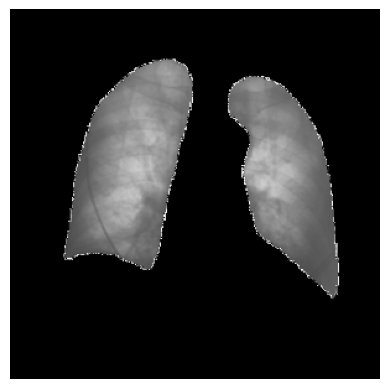

In [148]:


# Charger l'image radiographique et le masque 

image = Image.open('/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID/COVID-1.png') 
mask = Image.open('/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID-1.png') 

#Redimensionner le masque à la même taille que l'image
mask = mask.resize(image.size, resample=Image.Resampling.BILINEAR)

# Convertir les images en tableaux numpy 
image_np = np.array(image) 
mask_np = np.array(mask) 

#Le masque a trois canaux alors que l'image en a 2, du coup on leur donne le même nombre de canaux
image_np = np.stack((image_np,) * 3, axis=-1)

# Appliquer le masque sur l'image 
segmented_image_np = image_np * mask_np

#Afficher l'image
plt.imshow(segmented_image_np.astype('uint8'))
plt.axis('off')
plt.show()

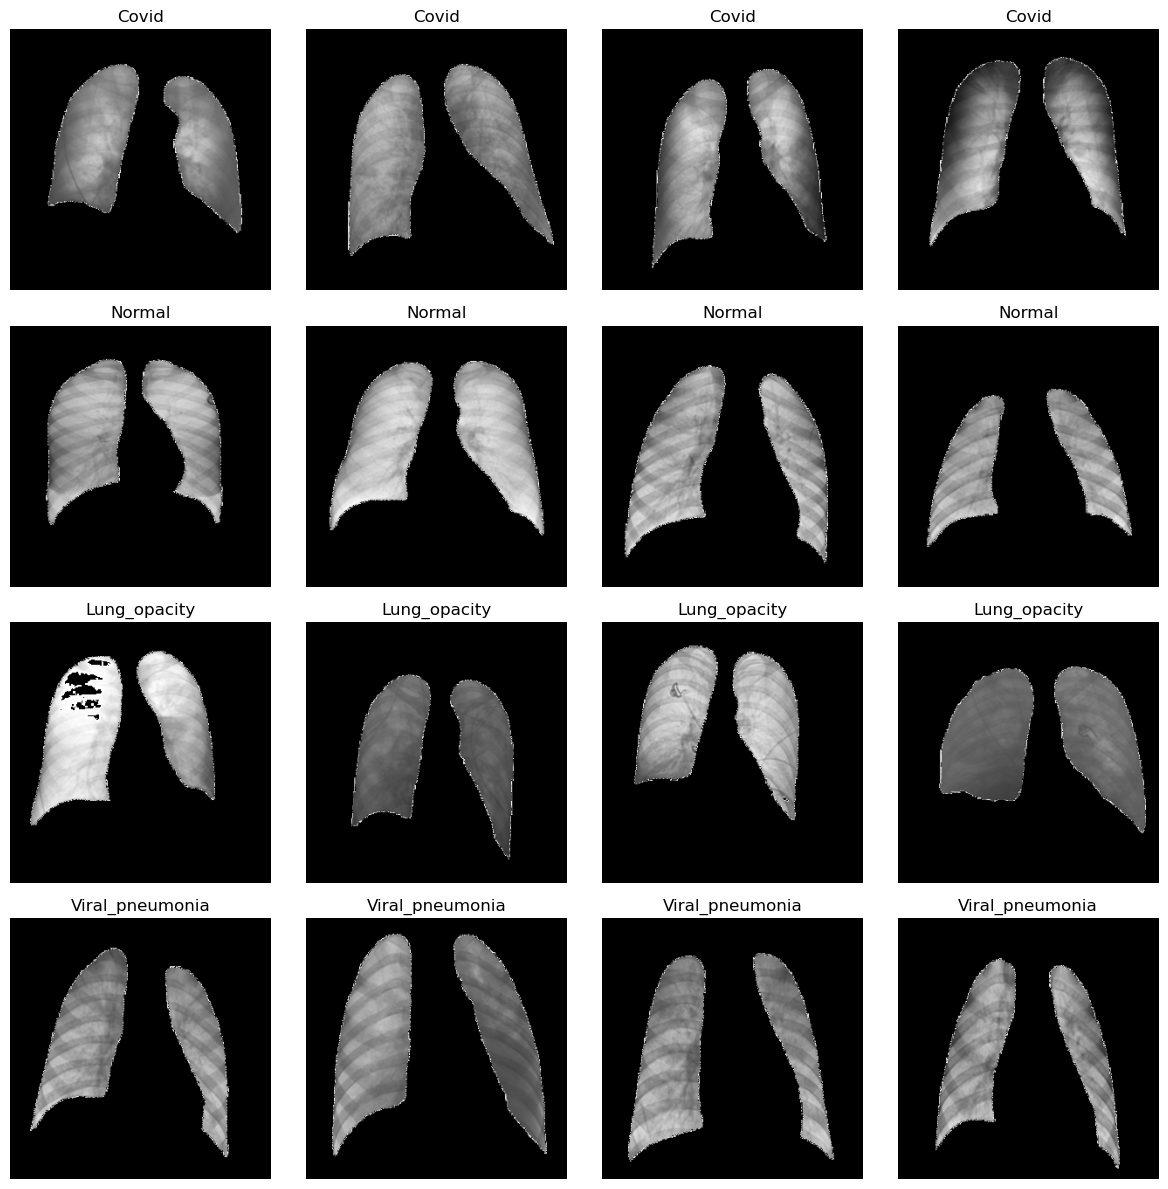

In [156]:
# Dossier contenant les images et les masques pour chaque type
image_folder = {
    "COVID": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID",
    "NORMAL": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL",
    "lung_opacity": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity",
    "viral_pneumonia": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia"
}

mask_folder = {
    'COVID': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID_mask',
    'NORMAL': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL_mask',
    'lung_opacity': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity_mask',
    'viral_pneumonia': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia_mask'
}

# Créer une nouvelle figure
plt.figure(figsize=(12, 12))

# Itérer sur chaque type d'image
for i, category in enumerate(image_folder.keys(), 1):
    # Chemins des dossiers d'images et de masques
    image_dir = image_folder[category]
    mask_dir = mask_folder[category]
    
    # Liste des noms de fichiers dans les dossiers
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    # Afficher les quatre premières images et leurs masques
    for j in range(4):
        # Charger l'image et le masque correspondant
        image_file = os.path.join(image_dir, image_files[j])
        mask_file = os.path.join(mask_dir, mask_files[j])
        image = Image.open(image_file).convert('RGB')
        mask = Image.open(mask_file).convert('L')
        
        # Redimensionner le masque pour correspondre à la taille de l'image
        mask = mask.resize(image.size, resample=Image.Resampling.BILINEAR)
        
        # Convertir les images en tableaux numpy
        image_np = np.array(image)
        mask_np = np.array(mask)
        
        # Dupliquer le masque pour avoir 3 canaux
        mask_np = np.expand_dims(mask_np, axis=-1)
        mask_np = np.concatenate([mask_np] * 3, axis=-1)
        
        # Appliquer le masque sur l'image
        segmented_image_np = image_np * mask_np
        
        # Ajouter la subplot pour l'image
        plt.subplot(4, 4, (i-1)*4 + j + 1)
        plt.imshow(segmented_image_np.astype('uint8'))
        plt.title(category.capitalize())  # Afficher le titre avec la catégorie en majuscules
        plt.axis('off')  # Désactiver les axes

# Ajuster l'espacement entre les subplots
plt.tight_layout()
plt.show()

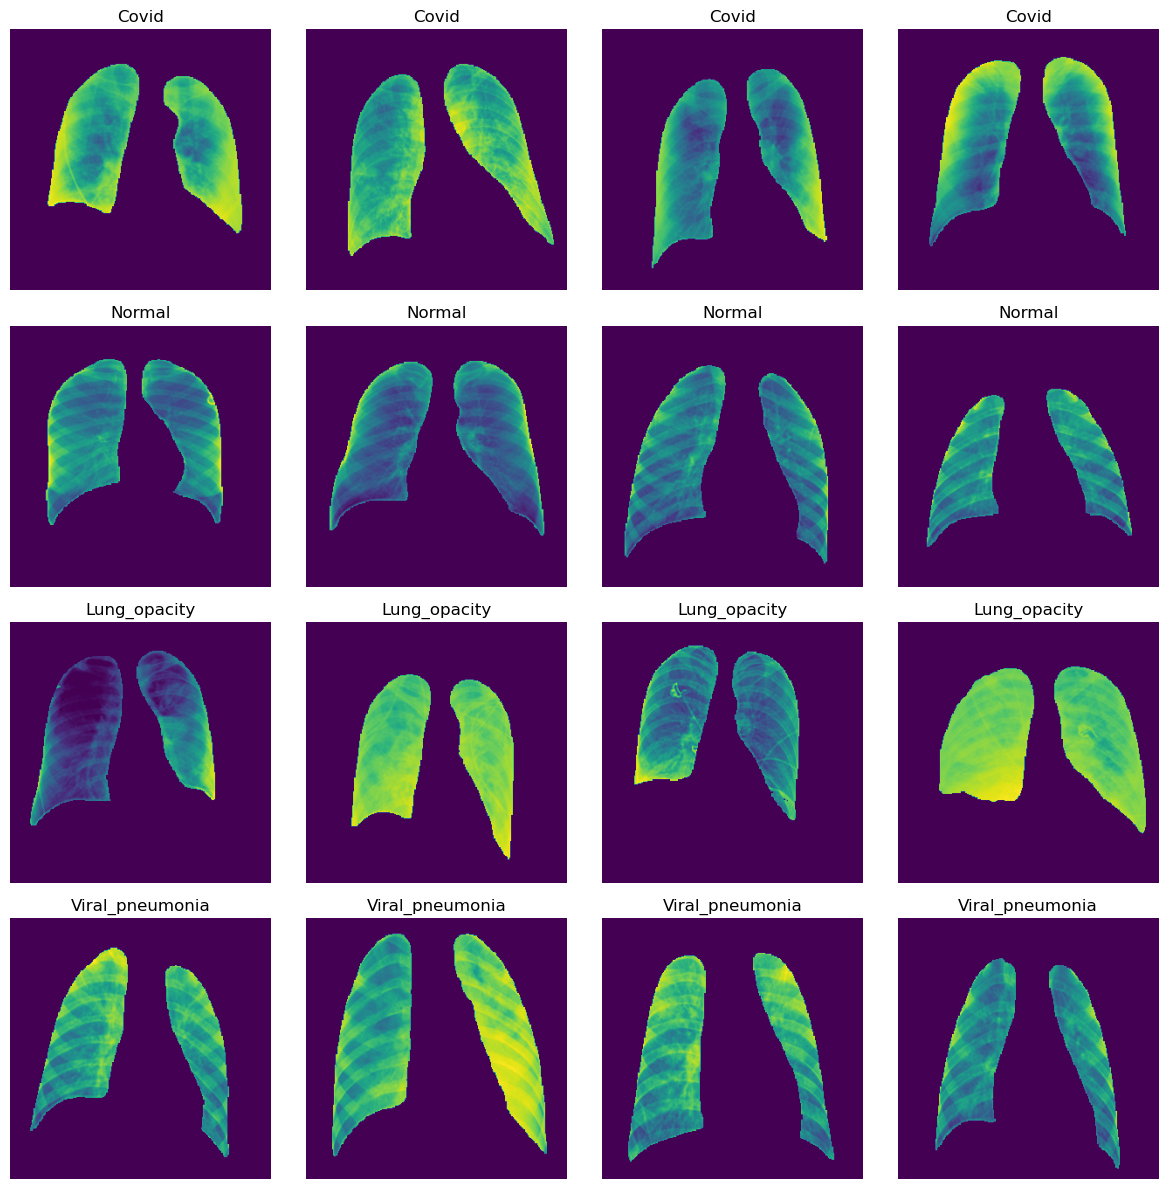

In [313]:
# Dossier contenant les images et les masques pour chaque type
image_folder = {
    "COVID": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID",
    "NORMAL": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL",
    "lung_opacity": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity",
    "viral_pneumonia": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia"
}

mask_folder = {
    'COVID': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID_mask',
    'NORMAL': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL_mask',
    'lung_opacity': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity_mask',
    'viral_pneumonia': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia_mask'
}

# Créer une nouvelle figure
plt.figure(figsize=(12, 12))

# Itérer sur chaque type d'image
for i, category in enumerate(image_folder.keys(), 1):
    # Chemins des dossiers d'images et de masques
    image_dir = image_folder[category]
    mask_dir = mask_folder[category]
    
    # Liste des noms de fichiers dans les dossiers
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    # Afficher les quatre premières images et leurs masques
    for j in range(4):
        # Charger l'image et le masque correspondant
        image_file = os.path.join(image_dir, image_files[j])
        mask_file = os.path.join(mask_dir, mask_files[j])
        image = Image.open(image_file).convert('L')  # Convertir en niveaux de gris
        mask = Image.open(mask_file).convert('L')
        
        # Redimensionner le masque pour correspondre à la taille de l'image
        mask = mask.resize(image.size, resample=Image.Resampling.BILINEAR)
        
        # Appliquer le masque sur l'image pour ne montrer que la zone délimitée par le masque
        masked_image = np.array(image)
        masked_image[np.array(mask) == 0] = 0
        
        # Ajouter la subplot pour l'image avec une colormap 'viridis'
        plt.subplot(4, 4, (i-1)*4 + j + 1)
        plt.imshow(masked_image, cmap='viridis')  # Afficher uniquement la zone délimitée par le masque
        plt.title(category.capitalize())  # Afficher le titre avec la catégorie en majuscules
        plt.axis('off')  # Désactiver les axes

# Ajuster l'espacement entre les subplots
plt.tight_layout()
plt.show()

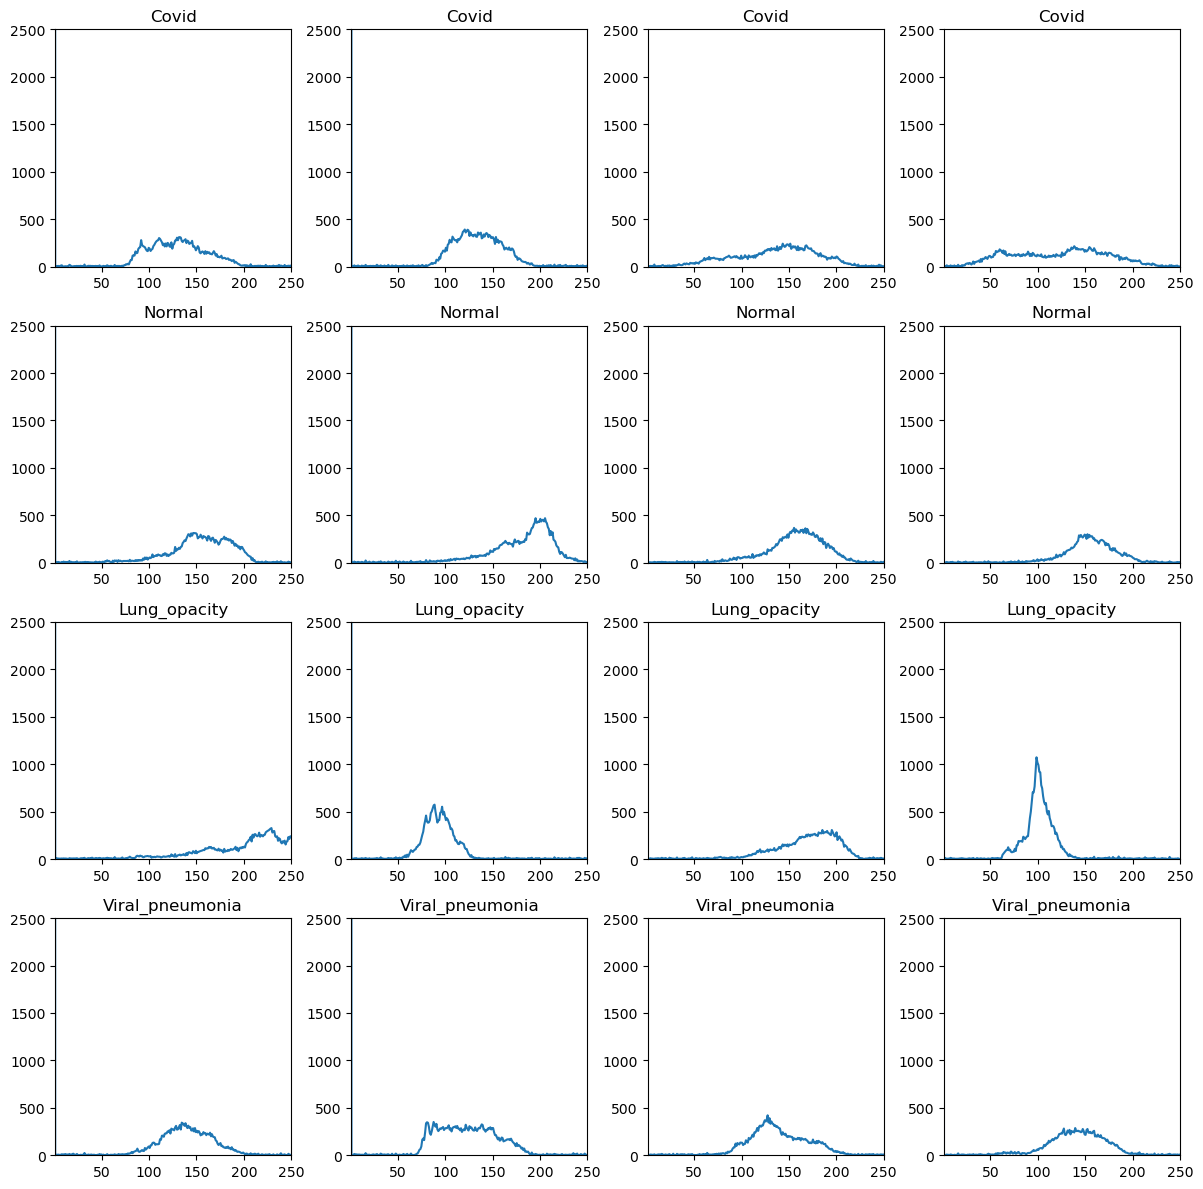

In [167]:
# Dossier contenant les images et les masques pour chaque type
image_folder = {
    "COVID": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID",
    "NORMAL": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL",
    "lung_opacity": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity",
    "viral_pneumonia": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia"
}

mask_folder = {
    'COVID': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID_mask',
    'NORMAL': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL_mask',
    'lung_opacity': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity_mask',
    'viral_pneumonia': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia_mask'
}

# Créer une nouvelle figure
plt.figure(figsize=(12, 12))

# Itérer sur chaque type d'image
for i, category in enumerate(image_folder.keys(), 1):
    # Chemins des dossiers d'images et de masques
    image_dir = image_folder[category]
    mask_dir = mask_folder[category]
    
    # Liste des noms de fichiers dans les dossiers
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    # Afficher les quatre premières images et leurs masques
    for j in range(4):
        # Charger l'image et le masque correspondant
        image_file = os.path.join(image_dir, image_files[j])
        mask_file = os.path.join(mask_dir, mask_files[j])
        image = Image.open(image_file).convert('RGB')
        mask = Image.open(mask_file).convert('L')
        
        # Redimensionner le masque pour correspondre à la taille de l'image
        mask = mask.resize(image.size, resample=Image.Resampling.BILINEAR)
        
        # Convertir les images en tableaux numpy
        image_np = np.array(image)
        mask_np = np.array(mask)
        
        # Dupliquer le masque pour avoir 3 canaux
        mask_np = np.expand_dims(mask_np, axis=-1)
        mask_np = np.concatenate([mask_np] * 3, axis=-1)
        
        # Appliquer le masque sur l'image
        segmented_image_np = image_np * mask_np
        
        # Calculer l'histogramme de niveaux de gris
        gray_histogram = np.histogram(segmented_image_np[:,:,0], bins=256, range=(0, 255))
        
        # Ajouter la subplot pour l'histogramme
        plt.subplot(4, 4, (i-1)*4 + j + 1)
        plt.plot(gray_histogram[1][:-1], gray_histogram[0])
        plt.title(category.capitalize())
        plt.ylim(0,2500)
        plt.xlim(1,250)

# Ajuster l'espacement entre les subplots
plt.tight_layout()
plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------

Test statistique ANOVA pour vérifier s'il y a une différence significative des niveaux de gris des 4 types de segmentations

In [184]:


# Chemin vers les répertoires contenant les images de chaque catégorie
directories = {
    "COVID": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID",
    "NORMAL": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL",
    "lung_opacity": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity",
    "viral_pneumonia": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia"
}

mask_folders = {
    'COVID': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID_mask',
    'NORMAL': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL_mask',
    'lung_opacity': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity_mask',
    'viral_pneumonia': '/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia_mask'
}

# Fonction pour récupérer les niveaux de gris d'une image segmentée
def get_segmented_grayscale_values(image_path, mask_path):
    # Charger l'image et le masque
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")
    # Redimensionner le masque pour correspondre aux dimensions de l'image
    mask = mask.resize(image.size, resample=Image.Resampling.BILINEAR)
    # Appliquer le masque sur l'image pour segmenter
    segmented_image = ImageChops.composite(image, Image.new("RGB", image.size, "black"), mask)
    # Récupérer les niveaux de gris de l'image segmentée
    grayscale_values = list(segmented_image.convert("L").getdata())
    return grayscale_values

# Listes pour stocker les niveaux de gris de chaque catégorie
grayscale_values_covid = []
grayscale_values_normal = []
grayscale_values_lung_opacity = []
grayscale_values_viral_pneumonia = []

# Parcourir les répertoires et récupérer les niveaux de gris de chaque image segmentée
for category, directory in directories.items():
    # Récupérer le répertoire des masques correspondant à la catégorie
    mask_folder = mask_folders[category]
    # Lister les fichiers dans le répertoire des images
    files = os.listdir(directory)
    # Récupérer les niveaux de gris de chaque image segmentée
    for file in files:
        # Construire le chemin d'accès complet de l'image et du masque
        image_path = os.path.join(directory, file)
        mask_path = os.path.join(mask_folder, file)
        # Récupérer les niveaux de gris de l'image segmentée
        grayscale_values = get_segmented_grayscale_values(image_path, mask_path)
        # Ajouter les niveaux de gris à la liste correspondante en fonction de la catégorie
        if category == "COVID":
            grayscale_values_covid.extend(grayscale_values)
        elif category == "NORMAL":
            grayscale_values_normal.extend(grayscale_values)
        elif category == "lung_opacity":
            grayscale_values_lung_opacity.extend(grayscale_values)
        elif category == "viral_pneumonia":
            grayscale_values_viral_pneumonia.extend(grayscale_values)

# Vérification
print("Nombre de niveaux de gris pour la catégorie COVID :", len(grayscale_values_covid))
print("Nombre de niveaux de gris pour la catégorie NORMAL :", len(grayscale_values_normal))
print("Nombre de niveaux de gris pour la catégorie lung_opacity :", len(grayscale_values_lung_opacity))
print("Nombre de niveaux de gris pour la catégorie viral_pneumonia :", len(grayscale_values_viral_pneumonia))


Nombre de niveaux de gris pour la catégorie COVID : 357604
Nombre de niveaux de gris pour la catégorie NORMAL : 357604
Nombre de niveaux de gris pour la catégorie lung_opacity : 357604
Nombre de niveaux de gris pour la catégorie viral_pneumonia : 357604


In [185]:
data = pd.DataFrame({
    'COVID': grayscale_values_covid,
    'NORMAL': grayscale_values_normal,
    'lung_opacity': grayscale_values_lung_opacity,
    'viral_pneumonia': grayscale_values_viral_pneumonia
})

# Test de Levene pour l'homoscédasticité
levene_statistic, levene_pvalue = levene(grayscale_values_covid, grayscale_values_normal, grayscale_values_lung_opacity, grayscale_values_viral_pneumonia)
print("Test de Levene pour l'homoscédasticité - Statistique :", levene_statistic)
print("P-valeur :", levene_pvalue)

# Test de Shapiro-Wilk pour la normalité des données
shapiro_statistic, shapiro_pvalue = shapiro(data.stack())
print("Test de Shapiro-Wilk pour la normalité des données - Statistique :", shapiro_statistic)
print("P-valeur :", shapiro_pvalue)

# Si les hypothèses sont satisfaites, effectuer l'ANOVA
if levene_pvalue > 0.05 and shapiro_pvalue > 0.05:
    # ANOVA
    anova_result = f_oneway(grayscale_values_covid, grayscale_values_normal, grayscale_values_lung_opacity, grayscale_values_viral_pneumonia)
    print("\nTest ANOVA - Statistique :", anova_result.statistic)
    print("P-valeur :", anova_result.pvalue)
    
    # Test de Tukey pour les comparaisons multiples
    tukey_result = pairwise_tukeyhsd(data.stack(), data.index.get_level_values(1))
    print("\nTest de Tukey pour les comparaisons multiples :\n", tukey_result)

else:
    # Test de Kruskal-Wallis
    kruskal_result = kruskal(grayscale_values_covid, grayscale_values_normal, grayscale_values_lung_opacity, grayscale_values_viral_pneumonia)
    print("Test de Kruskal-Wallis - Statistique :", kruskal_result.statistic)
    print("P-valeur :", kruskal_result.pvalue)



Test de Levene pour l'homoscédasticité - Statistique : 2398.9866444875947
P-valeur : 0.0


/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning:

p-value may not be accurate for N > 5000.



Test de Shapiro-Wilk pour la normalité des données - Statistique : 0.5768511891365051
P-valeur : 0.0
Test de Kruskal-Wallis - Statistique : 1965.1988125329578
P-valeur : 0.0


In [ ]:
# Dossiers contenant les images et les masques pour chaque catégorie
image_folders = {
    "COVID": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID",
    "NORMAL": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL",
    "lung_opacity": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity",
    "viral_pneumonia": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia"
}

mask_folders = {
    "COVID": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/COVID_mask",
    "NORMAL": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/NORMAL_mask",
    "lung_opacity": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/lung_opacity_mask",
    "viral_pneumonia": "/Users/Mac/Desktop/DataScientest/Projet_Datascientest/Exploration_DataViz/viral_pneumonia_mask"
}

# Normaliser les images et les masques
def normalize_image_and_mask(image, mask):
    # Convertir les images en tableaux numpy
    image_np = np.array(image)
    mask_np = np.array(mask)
    
    # Normaliser les images et les masques
    scaler = MinMaxScaler(feature_range=(0, 255))
    normalized_image = scaler.fit_transform(image_np.reshape(-1, 1)).reshape(image_np.shape)
    normalized_mask = scaler.fit_transform(mask_np.reshape(-1, 1)).reshape(mask_np.shape)
    
    return normalized_image, normalized_mask

# Sélectionner les 10 premières images et les 10 premiers masques de chaque catégorie
selected_images = []
selected_masks = []
for category, image_folder_path in image_folders.items():
    mask_folder_path = mask_folders[category]
    image_files = sorted(os.listdir(image_folder_path))[:10]
    mask_files = sorted(os.listdir(mask_folder_path))[:10]
    
    for image_file, mask_file in zip(image_files, mask_files):
        image_path = os.path.join(image_folder_path, image_file)
        mask_path = os.path.join(mask_folder_path, mask_file)
        
        # Charger les images et les masques
        image = Image.open(image_path).convert('L')  # Convertir en niveaux de gris
        mask = Image.open(mask_path).convert('L')
        
        # Redimensionner le masque pour correspondre à la taille de l'image si nécessaire
        mask = mask.resize(image.size, resample=Image.BILINEAR)
        
        # Normaliser les images et les masques
        normalized_image, normalized_mask = normalize_image_and_mask(image, mask)
        
        selected_images.append(normalized_image)
        selected_masks.append(normalized_mask)

# Afficher le résultat
print("Nombre d'images sélectionnées:", len(selected_images))
print("Nombre de masques sélectionnés:", len(selected_masks))

In [317]:
# Dossiers contenant les images et les masques pour chaque catégorie
image_folders = {
    "COVID": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/COVID/images",
    "NORMAL": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/Normal/images",
    "lung_opacity": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/Lung_Opacity/images",
    "viral_pneumonia": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/Viral_Pneumonia/images"
}


mask_folders = {
    "COVID": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/COVID/masks",
    "NORMAL": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/Normal/masks",
    "lung_opacity": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/Lung_Opacity/masks",
    "viral_pneumonia": "/Volumes/VALENTINE/Projet_Datascientest/COVID-19_Radiography_Dataset/Viral_Pneumonia/masks"
}

# Normaliser les images et les masques
def normalize_image_and_mask(image, mask):
    # Convertir les images en tableaux numpy
    image_np = np.array(image)
    mask_np = np.array(mask)
    
    # Normaliser les images et les masques
    scaler = MinMaxScaler(feature_range=(0, 255))
    normalized_image = scaler.fit_transform(image_np.reshape(-1, 1)).reshape(image_np.shape)
    normalized_mask = scaler.fit_transform(mask_np.reshape(-1, 1)).reshape(mask_np.shape)
    
    return normalized_image, normalized_mask

# Sélectionner les 10 premières images et les 10 premiers masques de chaque catégorie
selected_images = []
selected_masks = []
for category, image_folder_path in image_folders.items():
    mask_folder_path = mask_folders[category]
    image_files = sorted(os.listdir(image_folder_path))[:10]
    mask_files = sorted(os.listdir(mask_folder_path))[:10]
    
    for image_file, mask_file in zip(image_files, mask_files):
        image_path = os.path.join(image_folder_path, image_file)
        mask_path = os.path.join(mask_folder_path, mask_file)
        
        # Charger les images et les masques
        image = Image.open(image_path).convert('L')  # Convertir en niveaux de gris
        mask = Image.open(mask_path).convert('L')
        
        # Redimensionner le masque pour correspondre à la taille de l'image si nécessaire
        mask = mask.resize(image.size, resample=Image.Resampling.BILINEAR)
        
        # Normaliser les images et les masques
        normalized_image, normalized_mask = normalize_image_and_mask(image, mask)
        
        selected_images.append(normalized_image)
        selected_masks.append(normalized_mask)

# Afficher le résultat
print("Nombre d'images sélectionnées:", len(selected_images))
print("Nombre de masques sélectionnés:", len(selected_masks))

Nombre d'images sélectionnées: 40
Nombre de masques sélectionnés: 40


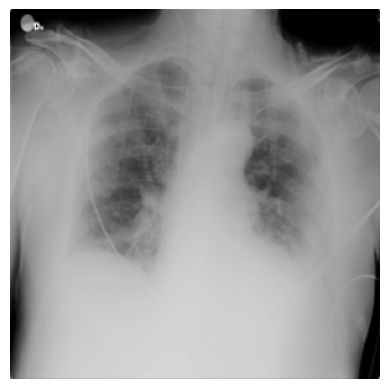

In [320]:
plt.imshow(selected_images[0], cmap='gray')
plt.axis('off')
plt.show()

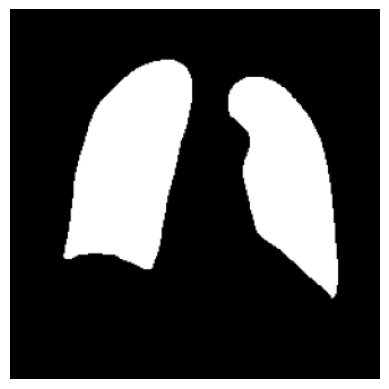

In [321]:
plt.imshow(selected_masks[0], cmap='gray')
plt.axis('off')
plt.show()

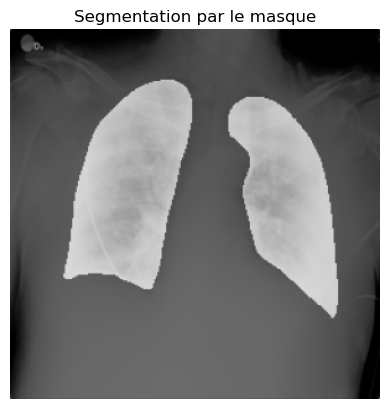

In [324]:
# Afficher la première image normalisée
plt.imshow(selected_images[0], cmap='gray')
plt.axis('off')
plt.title('Image')

# Afficher la segmentation de la première image par le premier masque
plt.imshow(selected_masks[0], cmap='gray', alpha=0.5)
plt.axis('off')
plt.title('Segmentation par le masque')
plt.show()

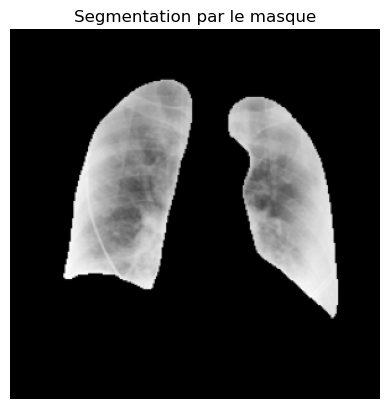

In [326]:
# Afficher uniquement la zone segmentée par le masque
plt.imshow(selected_images[0] * selected_masks[0], cmap='gray')
plt.axis('off')
plt.title('Segmentation par le masque')
plt.show()